# Time Series Analysis II

In this notebook we are going to be reviewing techniques for modeling time series based on fitting autoregressive and moving average components to the original data. ARMA (Autoregressive Moving Average) and ARIMA (Autoregressive Integrated Moving Average) methods are quite often used for forecasting or predicting the future temporal behavior of a system based on prior observations of that system.  As you'll see, ARIMA models don't require any additional or external predictors to model the time series - all that is needed is the time series itself and the ability to estimate parameters of coefficients that describe its behavior. 

## ARIMA Modeling 

As we will discuss in lecture, ARMA and ARIMA modeling attempt to capture persistence (autocorrelation) and shocks (moving average) components of the time series.  ARIMA adds a third 'Integrated' component related to differencing or trends.  

Let's start by looking at some models of the Mauna Loa CO2 record:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
# plt.rcParams['font.family'] = 'Helvetica'


Once again we'll read in the CO2 data into a Pandas DataFrame and create a datetime index:

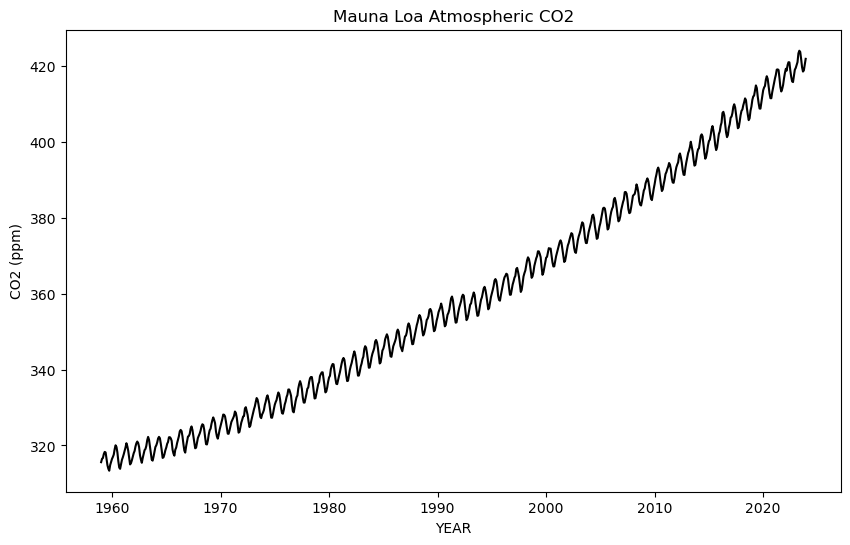

In [2]:
# get the CO2 data from the csv file
df = pd.read_csv('co2_mm_mlo.csv')

# combine 'year' and 'month' into a single new datetime column called 'date'
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))  # required to have 'day=1' here, which makes it a proper datetime value 

# now set the 'date' column as the index
df.set_index('date', inplace=True)

# now we can drop the columns that we aren't going to use - note you need to specify 'axis' for this drop operation
df.drop(['year', 'month'], axis=1, inplace=True) 

# and let's visualize our data
plt.figure(figsize=(10, 6))
plt.plot(df['co2'],'k')
plt.xlabel('YEAR')
plt.ylabel('CO2 (ppm)')
plt.title('Mauna Loa Atmospheric CO2')
plt.show()

We're now ready to fit an ARIMA model to the CO2 data.  First we'll get the ARIMA model from statsmodels.  We'll then specify the model parameters, create the model, fit the model, and compare the fitted values to the original data:

In [3]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

# ignore warning messages (about data frequency) from statsmodels for now - this isn't a problem for now
warnings.filterwarnings("ignore") 

# break out the CO2 column into a Pandas series
co2 = df['co2']

# declare the model order for each element
p = 1 # Autoregressive model component will be order 1
d = 1 # First differencing will be used
q = 1 # Moving average component of order 1 will be used

# create the ARIMA model
arima = ARIMA(co2, order = (p,d,q))

# fit the ARIMA model
arima_model_fit = arima.fit()

# get the fitted values from the model so we can compare to our data
co2_fitted_values = arima_model_fit.fittedvalues

# the ARMA model will be missing the first p values in the fitted values, so we make them a NaN (statsmodels makes them a zero, which is annoying and not helpful!)
co2_fitted_values.iloc[:p] = np.nan  


Let's plot the model fitted values and the original data:

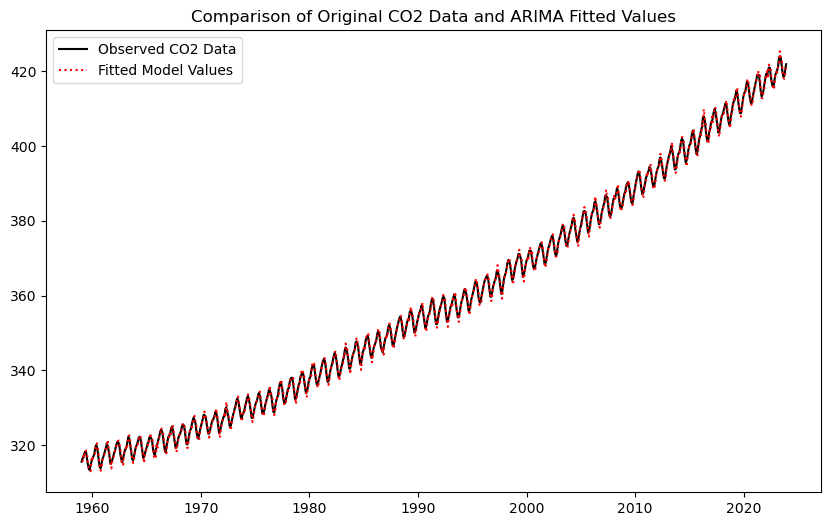

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(co2, color="k",label="Observed CO2 Data")
plt.plot(co2_fitted_values, label="Fitted Model Values", color='red',linestyle=':')
plt.legend()
plt.title("Comparison of Original CO2 Data and ARIMA Fitted Values")
plt.show()

Wow!  That's pretty impressive!  With an apparently simple and low-order model, we've recreated quite well the CO2 curve, including its trend and seasonal components!  

Let's look quickly at the residuals from the model fit:

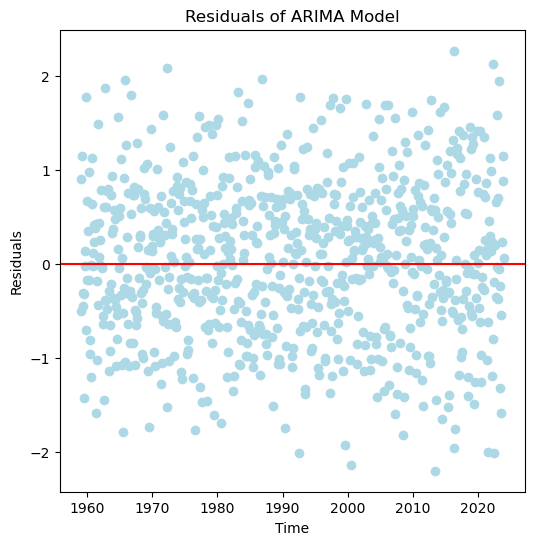

In [5]:
# Calculate the residuals (difference between actual and fitted values)
model_residuals = co2 - co2_fitted_values

# Plot residuals as a scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(co2.index, model_residuals, label="Residuals", color='lightblue')
plt.axhline(y=0, color='red')  # Add a horizontal line at y=0 for reference
plt.title("Residuals of ARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

Again, this is encouraging! The residuals are relatively small and show no trends or structure in time that would make us think the model fit was biased.  So far so good. 

## ARIMA Model Selection

Above we applied a first order constraint to the 3 model parameters.  But what if we don't know what the best model parameters might be?  This is a very common question in any time of modeling, including regression which we discussed previously. 

One approach is to try and fit lots and lots of model variants to the data and then compare their relative accuracy.  For this, we'll need to do a few things.  First, we'll decide on a range of possible model parameters (here we'll allow 0, 1, or 2 for each of the three parameters).  Next, we'll use the Python library `itertools` to create a list of all possible model parameter combinations.  Once we've done this, we can loop repeatedly and try different combinations of model parameters.  

How will we decide what is a best set of model parameters?  Here we can compare the AIC for each model, with the smallest AIC suggesting a balance between model complexity and model accuracy.  As we loop through and fit each model parameter set, we'll record the AIC and once we're done use it to select the best model:

In [10]:
# get the itertools functions, which allows us to create all possible combinations of variables - see here: https://docs.python.org/3/library/itertools.html
import itertools 

# Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 3) # allow 0, 1, 2 as the autogressive model order
d = range(0, 3) # allow 0, 1, 2 as the integrated (difference) model order
q = range(0, 3) # allow 0, 1, 2 as the moving average model order 

# Generate all the possible different combinations of p, d and q using the itertools.product function
pdq = list(itertools.product(p, d, q))

best_aic = np.inf # why infinity here? Because we are going to evaluate every model vs. the best model thus far (the smallest AIC), so the FIRST value of AIC has to be very large for the comparison 
best_pdq = None # this can be empty

# Create a list to store (parameters and AIC) values
aic_values = []

# Iterate over each combination of p, d, and q contained in the list pdq:
for param in pdq: # loop through all the possible model parameter sets we created
    
    # Create an ARIMA model with the current combination of parameters
    model = ARIMA(co2, order=param)
    
    # Fit the model
    results = model.fit()
    
    # Save the current parameters and AIC score
    aic_values.append([param[0], param[1], param[2], results.aic])
    
    # Uncomment this if you'd like to see the AIC score for the current model as we go through the loop - good for debugging! 
    # print("ARIMA{}: AIC={}".format(param, results.aic))
    
    # Check if the current model has the best (now lowest) AIC score, and if so replace the current 'best' pdq and AIC with it
    if results.aic < best_aic:
        best_aic = results.aic
        best_pdq = param

  
# convert the list of AIC values to a Pandas DataFrame for easier viewing
model_df = pd.DataFrame(aic_values, columns=['p', 'd', 'q', 'AIC']) # this now has all our parameters and AIC scores 

# print the DataFrame 
print(model_df)

# Then print the best model and its AIC score so we know which model was best
print("Best ARIMA model{} with AIC = {}".format(best_pdq, best_aic))

    p  d  q          AIC
0   0  0  0  7581.433931
1   0  0  1  6519.326456
2   0  0  2  5563.427500
3   0  1  0  2552.807808
4   0  1  1  2090.217305
5   0  1  2  1896.964889
6   0  2  0  2145.165600
7   0  2  1  2093.596252
8   0  2  2  2073.505128
9   1  0  0  2567.436098
10  1  0  1  2105.029167
11  1  0  2  1911.521754
12  1  1  0  2025.137371
13  1  1  1  1923.894844
14  1  1  2  1850.746308
15  1  2  0  2091.324634
16  1  2  1  2091.624586
17  1  2  2  1926.492254
18  2  0  0  2038.855214
19  2  0  1  1937.898292
20  2  0  2  1864.838230
21  2  1  0  1819.673349
22  2  1  1  1663.843554
23  2  1  2  1665.840184
24  2  2  0  2087.473543
25  2  2  1  1820.530099
26  2  2  2  1807.737293
Best ARIMA model(2, 1, 1) with AIC = 1663.8435540134615


We can see that many of the models with zero order parameters are poor (perhaps not surprisingly).  These scores might be easier to see if we plot them. Let's make a nice plot of AIC scores and model parameters to look at: 

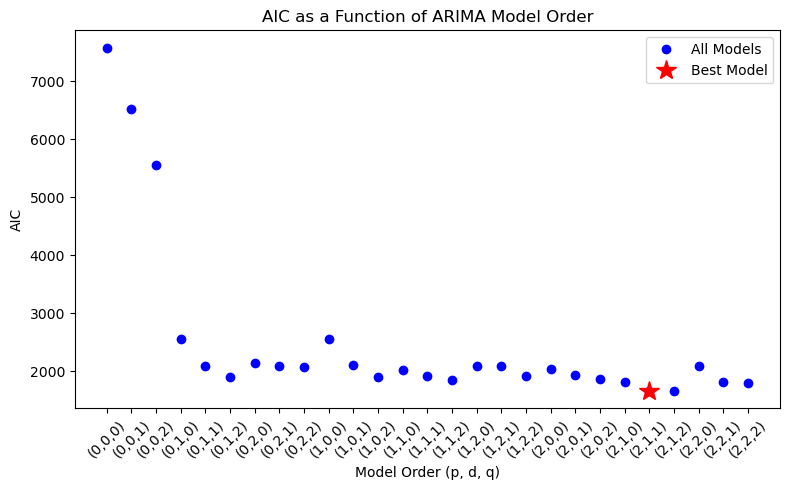

In [11]:
# Create a new column in the DataFrame to hold the (p, d, q) as a single string for labeling our x-axis
model_df['label'] = model_df.apply(lambda row: f"({int(row['p'])},{int(row['d'])},{int(row['q'])})", axis=1)

# Find the index of the best model using direct comparison to best_pdq tuple
best_index = model_df[(model_df['p'] == best_pdq[0]) & 
                      (model_df['d'] == best_pdq[1]) & 
                      (model_df['q'] == best_pdq[2])].index[0]

# make the plot
plt.figure(figsize=(8, 5))
plt.plot(model_df['label'], model_df['AIC'], marker='o', linestyle='', color='b',label="All Models")
plt.plot(best_index, best_aic, marker='*', color='r', markersize=15, linestyle='', label="Best Model")


plt.xticks(rotation=45) # Rotate x-axis labels so we can see them all
plt.xlabel('Model Order (p, d, q)')
plt.ylabel('AIC')
plt.title('AIC as a Function of ARIMA Model Order')
plt.legend()

plt.tight_layout()
plt.show()


A few observations:  Models with zero order parameters (which eliminate that component of the ARIMA model!) do poorly.  But there is a wide variety of model parameter sets that produce similar good (low) scores.  The best model has the lowest AIC, but we can see plenty of other combination that are close and would give similar results. 

Let's look at some residuals for our simple (1,1,1) model above and our 'best' model from the model fitting exercise:

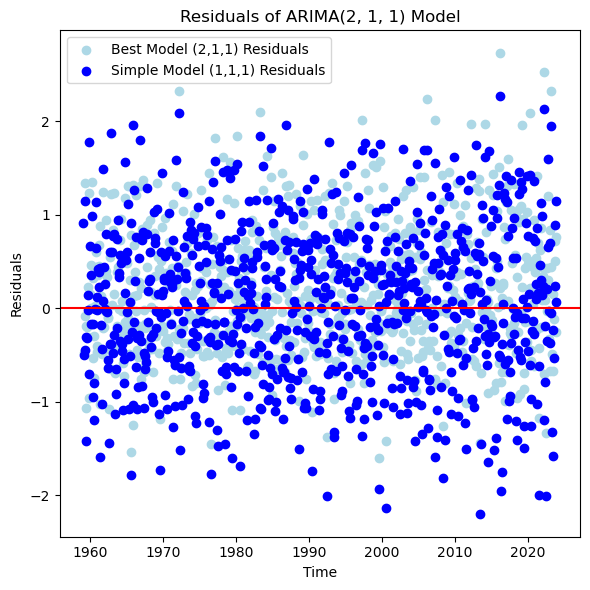

In [12]:
best_model = ARIMA(co2, order=best_pdq)
best_model_fit = best_model.fit()

# calculate residuals 
best_model_residuals = co2 - best_model_fit.fittedvalues

# the ARIMA model will be missing the first p values in the fitted values, so we make them a NaN 
best_model_residuals.iloc[:best_pdq[0]] = np.nan  

# Create the residual plot
plt.figure(figsize=(6, 6))
plt.scatter(co2.index,best_model_residuals, label='Best Model (2,1,1) Residuals', color='lightblue')
plt.scatter(co2.index, model_residuals, label="Simple Model (1,1,1) Residuals", color='blue')

plt.axhline(y=0, color='red', linestyle='-') 
plt.title(f'Residuals of ARIMA{best_pdq} Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

We can see that the model selection produced a slightly better model in terms of residuals, particularly for the negative residuals.  Some there was some benefit from the model selection exercise and the discovery of a better model parameter set, but the difference is relatively small. 

## Prediction

Remember that ARIMA is often used for time series prediction.  Let's see how this is done. 

First, we're going to bring in a function for scikit-leanr called `train_test_split` (see more [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)). This function provides an elegant way to divide up our data into training and testing subsets.  We can use this to evaluate our model's ability to make good predictors or forecasts. 

Let's do it.  

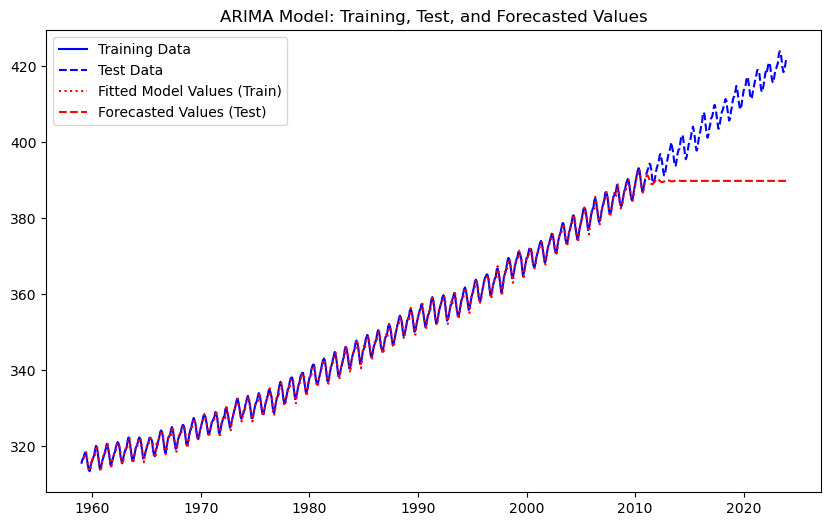

In [13]:
from sklearn.model_selection import train_test_split

# ignore warning messages from statsmodels (about data frequency in this case)
warnings.filterwarnings("ignore") 

# break out the CO2 column into a new Pandas series
co2 = df['co2']

# here we pre-define the size of the test set - here I'm making it ~20% of the total data and an integer
test_size = int(len(co2) * 0.2)

# split data into training and testing sets based on the size we determined above
train_data, test_data = train_test_split(co2, test_size=0.2, shuffle=False)

# declare the ARIMA model order from our 'best model' above
p = 2 # Autoregressive order
d = 1 # Differencing order
q = 1 # Moving average order

# Fit the ARIMA model on the training data now only
arima = ARIMA(train_data, order=(p, d, q))
arima_model_fit = arima.fit()

# forecast values for the withheld test set
forecasted_values = arima_model_fit.forecast(steps=len(test_data))

# get the fitted values from the training data fit
co2_fitted_values = arima_model_fit.fittedvalues

# fill the first `p` values with NaN as before
co2_fitted_values.iloc[:p] = np.nan  

# Now plot the training data, the test data, and the forecasted values for the test data
plt.figure(figsize=(10, 6))

# Plot observed training data
plt.plot(train_data, color="blue", label="Training Data")

# Plot observed test data
plt.plot(test_data.index, test_data, color="blue", linestyle='--',label="Test Data")

# Plot fitted values (for training data)
plt.plot(co2_fitted_values, label="Fitted Model Values (Train)", color='red', linestyle=':')

# Plot forecasted values (for the test data)
plt.plot(test_data.index, forecasted_values, label="Forecasted Values (Test)", color='red', linestyle='--')

plt.legend()
plt.title("ARIMA Model: Training, Test, and Forecasted Values")
plt.show()


Ack! What happened?  It looks like once the training period was over, the model just contininued the mean value at that point throughout the testing data period!  What happened, do you think? 

## What about a different model? SARIMA to the rescue! 


The problem above is that while the differencing parameter can handle the trend and seasonality when fit to the entire data, it doesn't have enough information in the ARIMA model for the behavior during the forecast period.  We need to give our model more information, in this case about the seasonal cycle!  For this we can use a model called [SARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) or (SARIMAX Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors). 

We'll get SARIMAX from statsmodels again.  Now we need to specify another set of parameters, including the period of seasonality (12 months in this case):
  

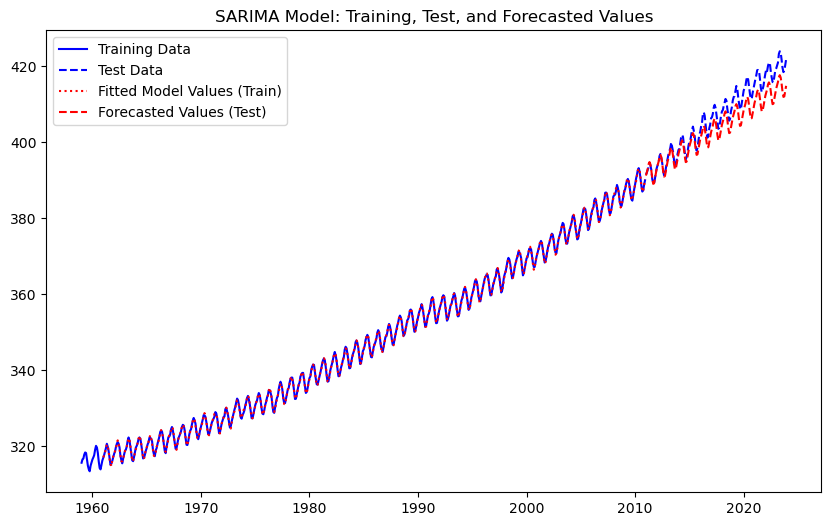

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming co2 is your time series data
co2 = df['co2']

# Split the data into training and testing sets using train_test_split
train_data, test_data = train_test_split(co2, test_size=0.2, shuffle=False)

# define SARIMA model order (p, d, q) for the NON-seasonal part 
p = 2  # Non-seasonal autoregressive order
d = 1  # Non-seasonal differencing order
q = 1  # Non-seasonal moving average order

# now the parameters of the seasonal component model (P, D, Q, s), where s is now the length of the seasonal cycle (so, 12 for monthly data with an annual cycle)
P = 1  # Seasonal Autoregressive model order
D = 1  # Seasonal Differencing model order
Q = 1  # Seasonal Moving average model order
s = 12  # Seasonal period (monthly data, so we'll use 12)

# Fit the SARIMA model on the training data
sarima = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima.fit(disp=0) # note here that adding disp=0 will suppress the model's verbose output, remove if you want the iterative output printed to screen

# Forecast values for the test set
forecasted_values = sarima_model_fit.forecast(steps=len(test_data))

# Get the fitted values from the training data
co2_fitted_values = sarima_model_fit.fittedvalues

# Set the first few values (e.g., first 12 months) to NaN
num_initial_values_to_remove = 24  # You can choose an appropriate number based on your model
co2_fitted_values.iloc[:num_initial_values_to_remove] = np.nan

# Plot the training data, test data, fitted values, and forecasted values
plt.figure(figsize=(10, 6))

# Plot observed training data
plt.plot(train_data, color="blue", label="Training Data")

# Plot observed test data
plt.plot(test_data.index, test_data, color="blue", linestyle="--",label="Test Data")

# Plot fitted values (for training data)
plt.plot(co2_fitted_values, label="Fitted Model Values (Train)", color='red', linestyle=':')

# Plot forecasted values (for the test data)
plt.plot(test_data.index, forecasted_values, label="Forecasted Values (Test)", color='red', linestyle='--')

plt.legend()
plt.title("SARIMA Model: Training, Test, and Forecasted Values")
plt.show()


Hmmm.  Better, but you can see the forecast doesn't keep up with the rising trend during the test period. 

We can try adding additional parameters to the SARIMA model.  For instance, here let's specify `trend='t'` in the SARIMAX model to indicate a (linear) trend

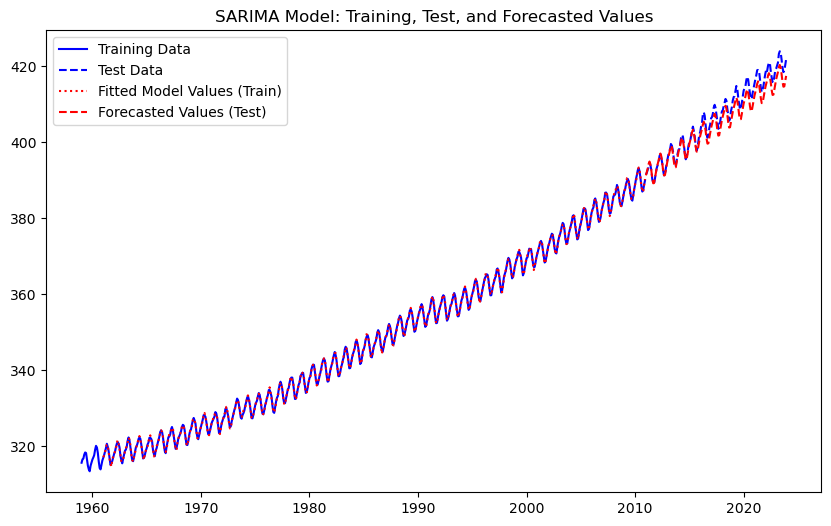

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming co2 is your time series data
co2 = df['co2']

# Split the data into training and testing sets using train_test_split
train_data, test_data = train_test_split(co2, test_size=0.2, shuffle=False)

# Define SARIMA model order (p, d, q) for non-seasonal part and (P, D, Q, s) for seasonal part
p = 2  # Non-seasonal autoregressive order
d = 1  # Non-seasonal differencing order
q = 1  # Non-seasonal moving average order

# Seasonal component model order: (P, D, Q, s) where s is the length of the seasonal cycle (e.g., 12 for monthly data with yearly seasonality)
P = 1  # Autoregressive model order
D = 1  # Differencing model order
Q = 1  # Moving average model order
s = 12  # Seasonal period (monthly data, so we'll use 12)

# Fit the SARIMA model on the training data
sarima = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s), trend='t') # options for trend are 'c' for constant, 't' for linear, and 'ct' for quadratic 
sarima_model_fit = sarima.fit(disp=0) # note that adding disp=0 will suppress the model's verbose output

# Forecast values for the test set
forecasted_values = sarima_model_fit.forecast(steps=len(test_data))

# Get the fitted values from the training data
co2_fitted_values = sarima_model_fit.fittedvalues

# Set the first few values (e.g., first 12 months) to NaN
num_initial_values_to_remove = 24  # You can choose an appropriate number based on your model
co2_fitted_values.iloc[:num_initial_values_to_remove] = np.nan

# Plot the training data, test data, fitted values, and forecasted values
plt.figure(figsize=(10, 6))

# Plot observed training data
plt.plot(train_data, color="blue", label="Training Data")

# Plot observed test data
plt.plot(test_data.index, test_data, color="blue", linestyle="--",label="Test Data")

# Plot fitted values (for training data)
plt.plot(co2_fitted_values, label="Fitted Model Values (Train)", color='red', linestyle=':')

# Plot forecasted values (for the test data)
plt.plot(test_data.index, forecasted_values, label="Forecasted Values (Test)", color='red', linestyle='--')

plt.legend()
plt.title("SARIMA Model: Training, Test, and Forecasted Values")
plt.show()


Hmmm, better, but still not quite right.  Why do you think the fit still isn't perfect? 

## Next Steps

1. Play with the components of the SARIMAX model - is it possible to get a better fit to the trend during the test period? 
2. Write a model selection loop for the SARIMAX model - what is the optimal model fit based on your evaluation of the AIC? 